# Membuat Klasifikasi Citra Sederhana Penyakit Daun Padi

## 1. Mengimport Semua Modul dan Paket

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

### 1.1. Mendefinisikan Input Gambar dalam Dataset

In [9]:
# Melakukan input Dataser berdasarkan direktori nya
image_dir = 'C:/Users/umalb/Dataset/dataset_kaggle_dedeikhsan/RiceLeafsDisease/train'
original_image_size = (1600,1600) # Ukuran Input dataset orisinil yang diketahui
target_image_size = (224,224) # Ukuran Input dataset yang menjadi target
batch_size = 32 # ukuran batch awal sebesar 32

# Mendapatkan path absolut dari direktori
current_directory = os.getcwd()
absolute_image_dir = os.path.join(current_directory, image_dir)

# Mengecek apakah direktori tersebut berjalan atau tidak
if not os.path.exists(absolute_image_dir):
    raise FileNotFoundError(f"Direktori {absolute_image_dir} tidak ditemukan")

# fungsi untuk meresize gambar
def resize_images(images, size):
    return tf.image.resize(images, size)

# Membuat Dataset Latihan (80% dari data total)
lat_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = absolute_image_dir, # Variabel Pengarahan Address Dataset
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = target_image_size, # untuk menspesifikasi ukuran gambar pada variabel
    batch_size = batch_size
)

# Membuat Dataset Validasi (20% dari data total)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = absolute_image_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = target_image_size,
    batch_size = batch_size
)
# Meresize gambar pada dataset latihan dan validasi

train_size = lat_dataset.map(lambda x, y: (resize_images(x, target_image_size), y))
val_size = val_dataset.map(lambda x, y: (resize_images(x, target_image_size), y))

#mendapatkan class names untuk latihan dan validasi
class_names_lat = lat_dataset.class_names
class_names_val = val_dataset.class_names
print(class_names_lat,"\n")
print(class_names_val)

Found 2100 files belonging to 6 classes.
Using 1680 files for training.
Found 2100 files belonging to 6 classes.
Using 420 files for validation.
['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot'] 

['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


### 1.2. Menampilkan Dataset Awal dari sampel acak sebanyak 20 gambar pada Dataset latihan dan validasi

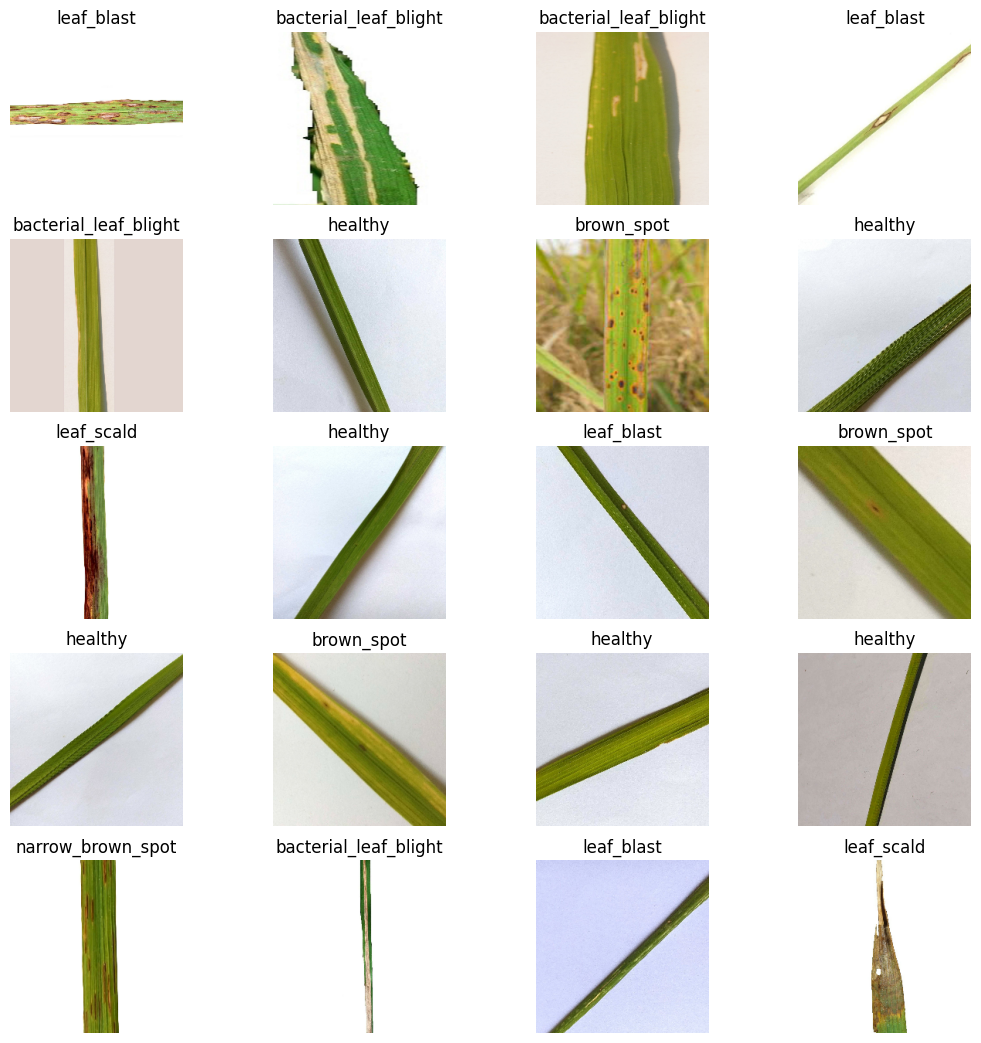

In [10]:
# Menampilkan 4x4 grid pada Gambar Latihan dari Dataset Tensorflow Menggunakan tf.keras
figure = plt.figure(figsize = (13,13))
for images, labels in lat_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names_lat[labels[i]])
        plt.axis('off')


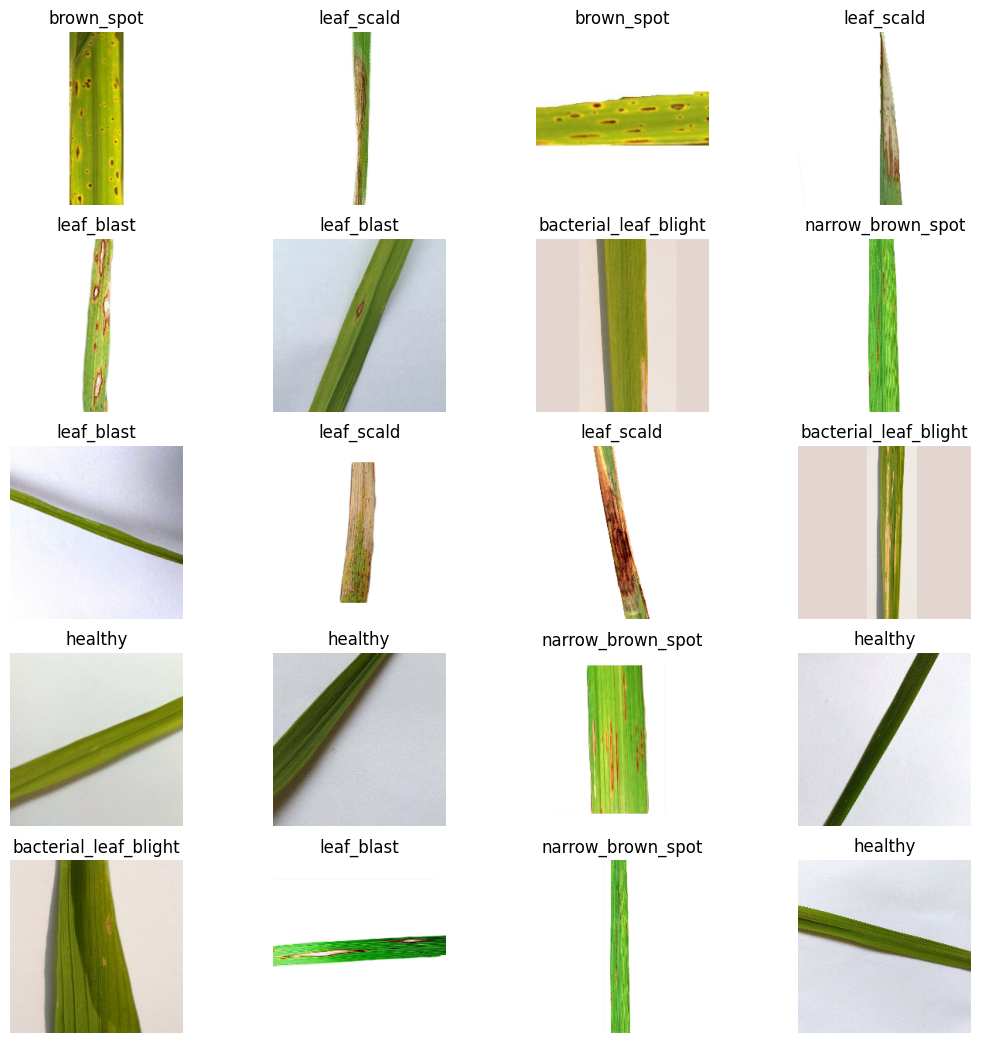

In [11]:
# Menampilkan 4x4 grid pada Gambar Latihan dari Dataset Tensorflow Menggunakan tf.keras
figure = plt.figure(figsize = (13,13))
for images, labels in val_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names_val[labels[i]])
        plt.axis('off')



## 2. Melakukan Ekstraksi Fitur Dataset 

### 2.1. Mendefinisikan Dataset Tensorflow dari Images Directory ataupun ImageNet

In [12]:
# Langkah 1 : Mendefinisikan dataset
def create_dataset(absolute_image_dir, target_image_size, batch_size):
    # Memuat dan memproses gambar dari direktori tersebut
    # Menggunakan ImageDataGenerator untuk Memuat dan Memproses gambar dari Direktori
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
    # Rescale gambar 1./255 digunakan untuk mengubah rentang pixel menjadi antara 0 dan 1
    dataset = datagen.flow_from_directory(
        directory = absolute_image_dir,
        target_size = target_image_size,
        batch_size = batch_size,
        class_mode = None,
        shuffle = False
    )
    return dataset

# Langkah 2 : Mendefinisikan ResNet50 Model untuk Ekstraksi Fitur
def create_resnet50_model(input_shape, num_classes_lat):
    # Memuat ResNet50 pra-latihan pada dataset ImageNet
    resnet = ResNet50(weights = 'imagenet', include_top=False, input_shape=input_shape)

    # Membekukan layer - layer awal pada model ResNet50
    for layer in resnet.layers:
        layer.trainable = False

    # Menambahkan layer Flatten
    x = Flatten()(resnet.output)

    # Menambahkan fully connected layer
    x = Dense(512, activation = 'relu')(x)

    # Output layer
    output = Dense(num_classes_lat, activation='softmax')(x)

    # Menggabungkan model
    resnet_model = Model(inputs=resnet.input, outputs=output)

    return resnet_model
## Memuat Dataset
dataset = create_dataset(absolute_image_dir, target_image_size, batch_size)

## menentukan kelas dataset
num_classes_lat = len(class_names_lat)
## Mendefinisikan model ResNet50
resnet_model = create_resnet50_model(input_shape=target_image_size + (3,), num_classes_lat=num_classes_lat)
resnet_model.summary()

# Langkah 3 : Mendeteksi penyakit daun padi dan menyediakan Bounding Boxes
def detect_and_bbox(dataset, resnet_model):
    predictions = resnet_model.predict(dataset, verbose = 1)
    return predictions

predictions = detect_and_bbox(dataset, resnet_model)

Found 2100 images belonging to 6 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 74,971,526 (285.99 MB)

 Trainable params: 51,383,814 (196.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

66/66 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step


### 2.2. Mengcompile ResNet50 dengan pendekatan Transfer Learning

In [13]:
# Menyusun Model ResNet50 dengan pendekatan untuk Transfer Learning
resnet_model.compile(optimizer='Adam',
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics = ['accuracy'])
num_epochs = 20
history = resnet_model.fit(lat_dataset,epochs = num_epochs, validation_data = val_dataset)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.6428 - loss: 17.6799 - val_accuracy: 0.8762 - val_loss: 1.4357
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.9301 - loss: 1.1633 - val_accuracy: 0.9095 - val_loss: 1.3944
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 213s 4s/step - accuracy: 0.9587 - loss: 0.5504 - val_accuracy: 0.9286 - val_loss: 1.1346
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.9836 - loss: 0.1479 - val_accuracy: 0.9167 - val_loss: 1.3205
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 240s 5s/step - accuracy: 0.9708 - loss: 0.4159 - val_accuracy: 0.9214 - val_loss: 1.2195
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - accuracy: 0.9819 - loss: 0.1762 - val_accuracy: 0.8881 - val_loss: 1.6987
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.9724 - loss: 0.2828 - val_accuracy: 0.9190 - val_loss: 1.5096
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.9889 - loss: 0.1230 - val_accuracy: 0.9190 - 

## 3. Membuat Plot untuk Loss pada Set Latihan dan Validasii

### 3.1. Membuat Plot

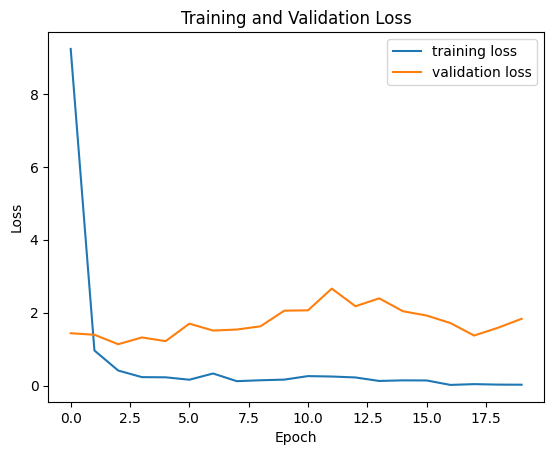

In [14]:
# Membuat Plot Latihan dengan Plot Validasi

plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3.2. Menampilkan nilai akurasi dan loss pada nilai set latihan dan validasi

In [15]:
# menampilkan nilai loss dan akurasi
loss,accuracy = resnet_model.evaluate(lat_dataset)
print(f"Training Loss {loss}")
print(f"Training Accuracy {accuracy}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.9993 - loss: 0.0139
Training Loss 0.020765749737620354
Training Accuracy 0.9982143044471741


In [16]:
#menampilkan nilai loss dan akurasi
loss, accuracy = resnet_model.evaluate(val_dataset)
print(f"Validation Loss {loss}")
print(f"Validation Accuracy {accuracy}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9113 - loss: 2.3382
Validation Loss 1.8321424722671509
Validation Accuracy 0.9238095283508301


## 4. Menampilkan konfusi Matriks pada Set Latihan dan Set Validasi

### 4.1. Konfusi Matriks Pada Set Latihan

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Penggunaan
num_runs = 5
dataset = lat_dataset

# Mendefinisikan Konfusi Matriks
def compute_confusion_matrix(resnet_model, dataset, num_runs):
    all_true_labels = []
    all_pred_labels = []

    for _ in range(num_runs):
        true_labels = []
        pred_labels = []

        # Membuat Prediksi dalam Dataset
        for features, labels in dataset:
            predictions = resnet_model.predict(features)
            true_labels.extend(labels.numpy())
            pred_labels.extend(np.argmax(predictions, axis=1))

        all_true_labels.append(true_labels)
        all_pred_labels.append(pred_labels)

    # Mengkomputasi Konfusi Matriks untuk tiap Running
    all_conf_matrix = [confusion_matrix(true_labels, pred_labels) for true_labels, pred_labels in zip(all_true_labels, all_pred_labels)]

    # Rerata Konfusi Matriks
    avg_conf_matrix = np.mean(all_conf_matrix, axis=0)

    return avg_conf_matrix

avg_conf_matrix = compute_confusion_matrix(resnet_model, dataset, num_runs)
print(f"Rerata Konfusi Matriks : \n\n {avg_conf_matrix}")

# Mengubah Konfusi Matriks menjadi integer
avg_conf_matrix = avg_conf_matrix.astype(int)
class_names_lat = class_names_lat

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

### 4.2. Membuat HeatMap Data Latihan

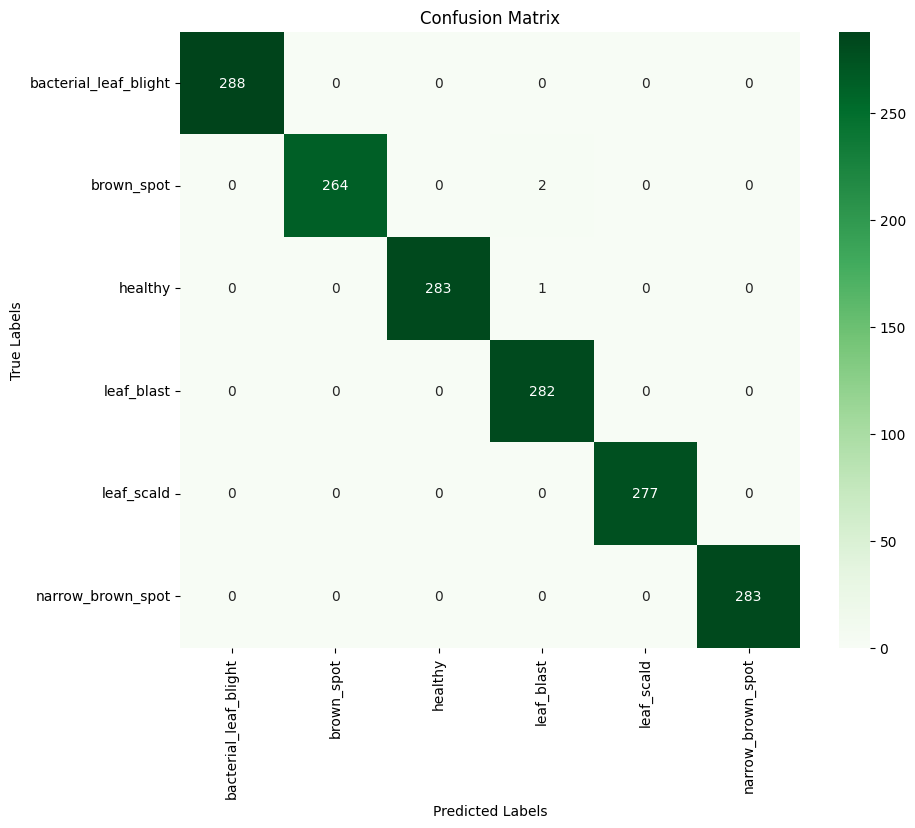

In [18]:
# Membuat Plot
plt.figure(figsize=(10,8))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=True,
           xticklabels=class_names_lat, yticklabels=class_names_lat)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### 4.3. Menampilkan Konfusi Matrix pada Set Validasi

In [19]:
# Penggunaan
num_runs = 5
dataset = val_dataset

# Mendefinisikan Konfusi Matriks
def compute_confusion_matrix(resnet_model, dataset, num_runs):
    all_true_labels = []
    all_pred_labels = []

    for _ in range(num_runs):
        true_labels = []
        pred_labels = []

        # Membuat Prediksi dalam Dataset
        for features, labels in dataset:
            predictions = resnet_model.predict(features)
            true_labels.extend(labels.numpy())
            pred_labels.extend(np.argmax(predictions, axis=1))

        all_true_labels.append(true_labels)
        all_pred_labels.append(pred_labels)

    # Mengkomputasi Konfusi Matriks untuk tiap Running
    all_conf_matrix = [confusion_matrix(true_labels, pred_labels) for true_labels, pred_labels in zip(all_true_labels, all_pred_labels)]

    # Rerata Konfusi Matriks
    avg_conf_matrix = np.mean(all_conf_matrix, axis=0)

    return avg_conf_matrix

avg_conf_matrix = compute_confusion_matrix(resnet_model, dataset, num_runs)
print(f"Rerata Konfusi Matriks : \n\n {avg_conf_matrix}")

# Mengubah Konfusi Matriks menjadi integer
avg_conf_matrix = avg_conf_matrix.astype(int)
class_names_lat = class_names_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### 4.4. Membuat Heatmap untuk Set Validasi

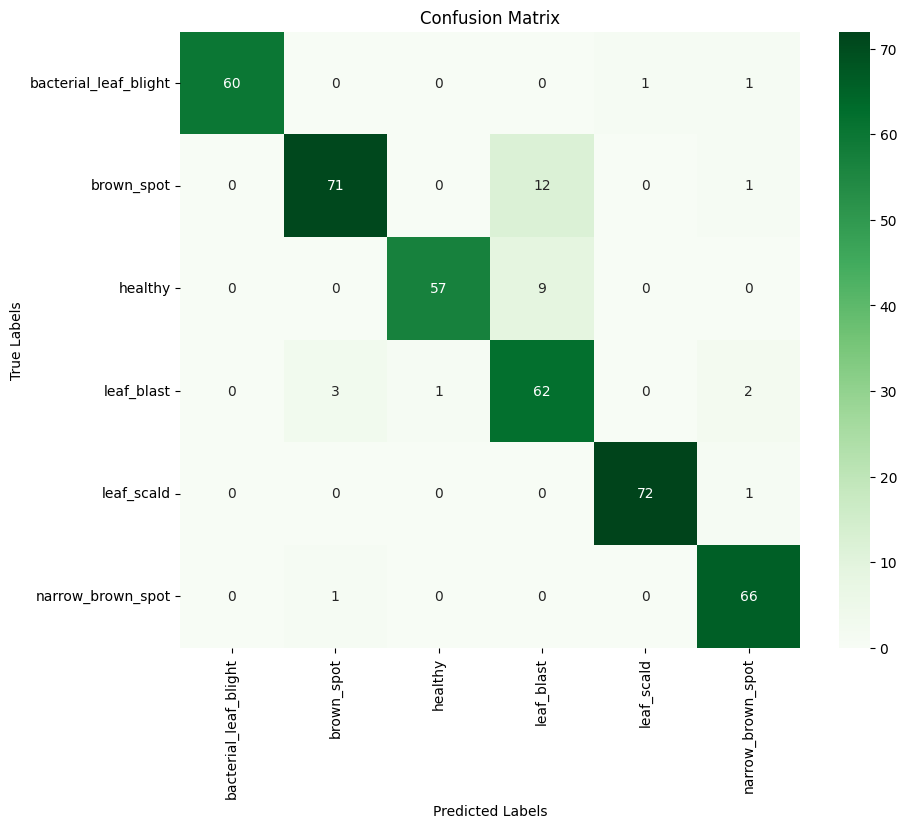

In [20]:
# Membuat Plot
plt.figure(figsize=(10,8))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=True,
           xticklabels=class_names_lat, yticklabels=class_names_lat)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 5. Menampilkan Laporan Klasifikasi

### 5.1. Pada Data Latihan

In [21]:
from sklearn.metrics import classification_report
import pandas as pd
# Contoh Penggunaan
num_runs = 5
dataset = lat_dataset


def compute_classification_report(model, dataset):
    true_labels = []
    pred_labels = []

    # membuat prediksi pada dataset
    for features, labels in dataset:
        predictions = resnet_model.predict(features)
        true_labels.extend(labels.numpy())
        pred_labels.extend(np.argmax(predictions, axis=1))

    # Mengkomputasikan laporan Klasifikasi
    classification_report_str = classification_report(true_labels, pred_labels)
    return classification_report_str


# Mengkomputasi Hasil Laporan Klasifikasi
classification_report_result = compute_classification_report(resnet_model, dataset)

# Menampilkan Laporan Klasifikasi
print(f"Classification Report :\n\n {classification_report_result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

### 5.2. Pada Data Validasi

In [22]:
# Contoh Penggunaan
num_runs = 5
dataset = val_dataset


def compute_classification_report(model, dataset):
    true_labels = []
    pred_labels = []

    # membuat prediksi pada dataset
    for features, labels in dataset:
        predictions = resnet_model.predict(features)
        true_labels.extend(labels.numpy())
        pred_labels.extend(np.argmax(predictions, axis=1))

    # Mengkomputasikan laporan Klasifikasi
    classification_report_str = classification_report(true_labels, pred_labels)
    return classification_report_str


# Mengkomputasi Hasil Laporan Klasifikasi
classification_report_result = compute_classification_report(resnet_model, dataset)

# Menampilkan Laporan Klasifikasi
print(f"Classification Report :\n\n {classification_report_result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
Classification Report :

               precision    recall  f1-score   support

           0       1.00      0.97      0.98        62
           1       0.95      0.85      0.89        84
           2       0.98      0.86      0.92        66
           3       0.75      0.91      0.82        68
           4       0.99      0.99      0.99        73
           5       0.93      0.99      0.96        67

    accuracy                           0.92       420
   macro avg       0.93      0.93